<a href="https://colab.research.google.com/github/AgreshB/Coursework-2-Text-Mining/blob/techni_sentiment/preprocessing_sma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Library installation/import

Install and import libraries that are used in multiple sections of the pipeline.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install spacy==3.0
!pip install tweepy
!pip install wordcloud

## Configuring Twitter API keys

Please note that the API keys below are the course leader's own API keys. You are allowed to use it to do some small tests, but please be careful because all students in the class now have a copy of it, and hence the limits can be easily exceeded.

If your group has decided to use Twitter data, you can [apply for your own keys](https://developer.twitter.com/en/apply-for-access).

In [2]:
import tweepy

auth = tweepy.OAuthHandler('fjkruboMzTLE4BLE7FmEpkWpw', 'jDobYz45Ksc3uMHoD2QnyZK60NwfRZnWIDVmyPtUGLkiOUqfGl')
auth.set_access_token('1374773661861830658-lPZKU2qeuepRxVfWs5OxRoZd6XGzrH', '84k6xIDIMrt5mzPFLCoesD0WM9bpk8d3bAKaNonbcuT0s')

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

## Downloading of new data set

**IMPORTANT NOTE**: Please do not run the cell below unless intending to download a new data set.

Make sure that you change the parameters.

Also, check the [Tweepy API reference](https://docs.tweepy.org/en/latest/api.html) to find out about other ways through which you can retrieve tweets, e.g., by specifying usernames.

In [ ]:
# Collect tweets
query = "remote work" + " -filter:retweets"
cutoff_date = "2021-01-01"
tweets = tweepy.Cursor(api.search, q=query, lang="en", result_type='mixed').items(1000)

tweets_list = [[tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=['id', 'date', 'user', 'location', 'text'])

# A good idea to save downloaded tweets as CSV
tweets_df.to_csv ('current_set.csv', quotechar='"', encoding='utf8', index = False, header=True)

In [72]:
# function to collect tweets by ketword querying
def tweet_collector(query_key: str, filename: str, result_type='mixed', maxNoTweets=1000):
  query = query_key + " -filter:retweets"
  # support for cutoff_date removed in tweepy 3.8 idk why they still have it here
  # cutoff_date = "2021-01-01"
  tweets = tweepy.Cursor(api.search, q=query, lang="en", result_type=result_type).items(maxNoTweets)

  tweets_list = [[tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

  tweets_df = pd.DataFrame(data=tweets_list, columns=['id', 'date', 'user', 'location', 'text'])

  # A good idea to save downloaded tweets as CSV
  tweets_df.to_csv (f'{filename}.csv', quotechar='"', encoding='utf8', index = False, header=True)

In [ ]:
# these queries have already been made, no point querying using these keywords
# again

# tweet_collector(query='remote work', filename='current_set')
# tweet_collector(query='work from home', filename='current_set_B')
# tweet_collector(query='#wfh', filename='current_set_C')
# tweet_collector(query='#workfromhome', filename='current_set_D')
# tweet_collector(query='remote work from home lifestyle', filename='current_set_E')
# tweet_collector(query='#workingfromhome', filename='current_set_F')

In [57]:
# after creating a new set of tweets/csv file add the filename here
all_filenames = [
  'current_set', 
  'current_set_B', 
  'current_set_C', 
  'current_set_D', 
  'current_set_E', 
  'current_set_F'
]

### USA DATA (tried something, didnt work)

In [ ]:
import os
import pickle

In [ ]:
list_tweet_id_csv = pd.read_csv('Tweets_United_States.csv')
list_tweet_id = list_tweet_id_csv['Tweet_ID'].tolist()

In [ ]:
# result path 
dir_result = './downloaded_json/'
os.makedirs(dir_result, exist_ok=True)

# tweet id 
# list_tweet_id = ['1240065380451844098', '1240065380305063938', '1240065380460216320', '1240065380334407681', '1253403812770938881', '1241850849749499910', '1253089038615134216', '1241947591631409152', '1245525634614468610', '1242612594101420034', '1244661129651068929', '1245129508434464772', '1227708779585818632', '1241640312356966400', '1253376415661252610', '1221082977431670786']
# download json batch by batch (The batch size should be less than 20. Otherwise, your credentials may be frozen by Twitter)
batch_size = 10
# construct your own batch_tweet by feeding tweet_id in list_tweet_id
for i in range(3423, int(len(list_tweet_id)/batch_size)):
  # construct the batch of tweets
  print(i)
  batch_tweet = list_tweet_id[i*batch_size:(i+1)*batch_size]
  set_status = api.statuses_lookup(batch_tweet)
  tweets_list = []
  for tweet in set_status:
    tweets_list.append([tweet.id, tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text])

  tweets_df = pd.DataFrame(data=tweets_list, columns=['id', 'date', 'user', 'location', 'text'])

  # A good idea to save downloaded tweets as CSV
  tweets_df.to_csv (f'current_set_USA_{i}.csv', quotechar='"', encoding='utf8', index = False, header=True)

In [ ]:
!zip -r /content/sample_data/files.zip /content/*

In [ ]:
from google.colab import files
files.download("/content/files.zip")

# Data pre-processing

## Cleaning

Below we provide some code for text cleaning. However, we encourage you to think of other ways to clean your data, e.g., by removing hashtags, removing usernames, removing duplicate tweets?

In [ ]:
#installing tweet-preprocessor
!pip install tweet-preprocessor
!pip install wordsegment
import preprocessor as p
from wordsegment import load, segment
import re

In [60]:
# combine the individual csv files

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f'{fname}.csv') for fname in all_filenames])
#export to csv
combined_csv.to_csv( "combined_.csv", index=False, encoding='utf8')

In [61]:
# comment if not using pre saved data set 
tweets_df = pd.read_csv('combined_.csv', quotechar='"', encoding='utf8')
cleaned_tweets = []

# include hastags and remove urls and emojis and mentions
#p.set_options(p.OPT.URL, p.OPT.EMOJI,p.OPT.MENTION)
for tweet in tweets_df['text']:
    cleaned_tweets.append(p.clean(tweet))

# adding back to data frame
tweets_df['text_processed'] = cleaned_tweets

#removing punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[,\\.!?]', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

#removing hastags for now 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"#(\w+)","",x))

#removing extra whitespaces 
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join(x.split()))


display(tweets_df)

,id,date,user,location,text,text_processed
0,1376530789177905153,2021-03-29 13:44:49,IngrahamAngle,DC,Now do Florida. Then ask yourselves who handl...,now do florida then ask yourselves who handled...
1,1376542205754621952,2021-03-29 14:30:11,nytimes,New York City,The coronavirus prompted a tectonic shift in h...,the coronavirus prompted a tectonic shift in h...
2,1376164425405710338,2021-03-28 13:29:01,ASCD,"Alexandria, VA (D.C. area)",Feedback’s main purpose is to improve the stud...,feedbacks main purpose is to improve the stude...
3,1376713727190392838,2021-03-30 01:51:45,Sally_bak_,"Ohio, USA",@thoughtwax Remote work provides new access to...,remote work provides new access to talent wher...
4,1376713711851831301,2021-03-30 01:51:41,Sally_bak_,"Ohio, USA",@willmendesneto @NearForm Remote work provides...,remote work provides new access to talent wher...
...,...,...,...,...,...,...
5009,1374708380053483526,2021-03-24 13:03:13,CopyritefurnKe,"Nairobi, Kenya",Invest on your comfort now rather than spend o...,invest on your comfort now rather than spend o...
5010,1374707893061218305,2021-03-24 13:01:17,TWEETPRESSS,united States,"THE WORLD’S FIRST SUPER AFFILIATE WEAPON, STAR...",the worlds first super affiliate weapon start ...
5011,1374707724479500291,2021-03-24 13:00:37,kogoltd,"East Grinstead, England",Video conferencing is now becoming mainstream....,video conferencing is now becoming mainstream ...
5012,1374707380131225602,2021-03-24 12:59:14,MarieCrawley8,"Ealing, London",@LandAPaperCo Wonderful stationery goodies!\n#...,wonderful stationery goodies


## Exploration using a word cloud

Generating a word cloud is one way by which you can check whether your data needs any further cleaning.

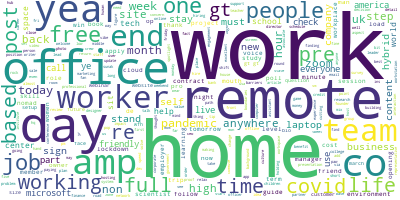

In [82]:
from wordcloud import WordCloud

unique_tweets = tweets_df['text_processed']

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

In [98]:
def generate_word_cloud(processed_tweet_list: list, max_words=500):
  # join the words of the different tweets together into one string
  long_string = ' '.join(processed_tweet_list)
  new_long_string = ' '.join(set(long_string.split(" ")))

  # create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=max_words, contour_width=3, contour_color='steelblue')

  # generate a word cloud
  wordcloud.generate(new_long_string)

  # visualize the word cloud
  return wordcloud.to_image()

# Topic Modelling

In [ ]:
!pip install -U gensim

In [83]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

print(stop_words)

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [ ]:
from pprint import pprint

# set number of topics
num_topics = 12

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# visualise the topics
!pip install pyldavis

In [ ]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './'+ str(num_topics) +'.html')

LDAvis_prepared

# Sentiment Analysis

This implementation is based on the lexicon- and rule-based [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis tool.

In [ ]:
# !pip install vaderSentiment

In [ ]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# analyzer = SentimentIntensityAnalyzer()

# for tweet_text in unique_tweets:
#     vs = analyzer.polarity_scores(tweet_text)
#     if (vs['pos'] > 0.5):
#       print(tweet_text + '\t' + str(vs))

In [ ]:
# TextBlob sentiment analysis
!pip install TextBlob
from textblob import TextBlob

In [69]:
negative_tweets = []
positive_tweets = []
neutral_tweets = []

for tweet_text, tweet_id in zip(tweets_df['text_processed'], tweets_df['id']) :
  blob = TextBlob(tweet_text)
  if blob.sentiment.subjectivity >= 0.5:
    if blob.sentiment.polarity >= 0.5:
      positive_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})
    elif blob.sentiment.polarity <= -0.5:
      negative_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})
    elif blob.sentiment.polarity >= -0.1 and blob.sentiment.polarity <= 0.1:
      neutral_tweets.append({'id': tweet_id, 'text_processed': tweet_text, 'sentiment': blob.sentiment})

65
493
446


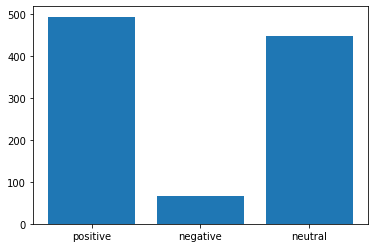

In [100]:
# for x in neutral_tweets:
#   print(f"text: {x['text_processed']}\nblob: {x['sentiment']}\n\n")

print(len(negative_tweets))
print(len(positive_tweets))
print(len(neutral_tweets))
total_sentiment_tweets = len(positive_tweets) + len(negative_tweets) + len(neutral_tweets)

# raw no. of tweets postive, negative, neutral
plt.bar(['positive', 'negative', 'neutral'], [len(positive_tweets), len(negative_tweets), len(neutral_tweets)])
plt.show()

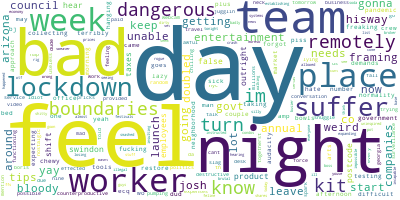

In [99]:
# word cloud for negative tweets
generate_word_cloud([tweet['text_processed'] for tweet in negative_tweets])

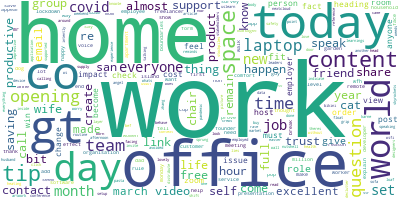

In [101]:
# word cloud for positive tweets
generate_word_cloud([tweet['text_processed'] for tweet in positive_tweets])

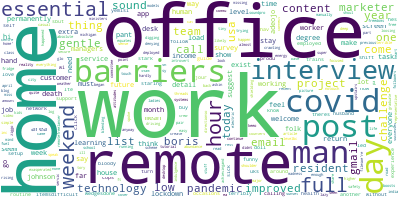

In [102]:
# word cloud for neutral tweets
generate_word_cloud([tweet['text_processed'] for tweet in neutral_tweets])

# Named Entity Recognition


This implementation is based on [spaCy's model](https://spacy.io/models/en#en_core_web_trf) using contextualised embeddings.

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')


In [ ]:
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  print(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])


# Named Entity Linking

This implementation is based on [spaCy Entity Linker](https://github.com/egerber/spacy-entity-linker).

In [ ]:
!pip install spacy-entity-linker
!python -m spacyEntityLinker "download_knowledge_base"

In [ ]:
from spacyEntityLinker import EntityLinker
from spacy.language import Language

@Language.factory(
   "entityLinker"
)
def create_linker(nlp, name):
  return EntityLinker()

#add to pipeline
nlp.add_pipe('entityLinker')

In [ ]:
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  print(tweet_text)
  all_linked_entities = doc._.linkedEntities
  all_linked_entities.pretty_print()
